# Emotion Recognition On Audio - CNN Model

## Importing needed libraries

In [1]:
!pip install tensorflow-addons
!pip install sentencepiece
!pip install tensorflow_hub
!pip install transformers
!pip install pytest


# System Libraries
import os
from pathlib import Path
import tarfile
from IPython.display import Audio, clear_output

# Handling Data Libraries
import pandas as pd
import numpy as np
import sentencepiece
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Plot Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Transformer models Libraries and utilities, metrics
from sklearn.metrics import classification_report, f1_score
from keras.utils.data_utils import get_file
from keras.utils.data_utils import get_file
from transformers import AlbertTokenizer, TFAlbertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import tensorflow_hub as hub
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Download of the chosen model and its tokenizer
print('Using TensorFlow version', tf.__version__)
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
albert = TFAlbertModel.from_pretrained("albert-base-v2")


random_seed = 42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Using TensorFlow version 2.12.0


Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


## Preprocessing

### Dataset download

In [2]:
from google.colab import files

def download_dataset_from_kaggle_to_colab():
    files.upload()
    !ls -lha kaggle.json
    !pip install -q kaggle # Install kaggle API
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d riccardopaolini/nlp-project-work
    !unzip nlp-project-work.zip
    clear_output()

download_dataset_from_kaggle_to_colab()

### Dataset conversion into table

In [3]:
def build_IEMOCAP_dataframe():
    folder = os.path.join(os.getcwd(), 'IEMOCAP')

    conv_id = 0

    df = []
    for session in os.listdir(folder):
        session_path = os.path.join(folder, session)
        # 'dialogue' folder contains Emotions and Transcripts
        # 'sentences' folder contains Audios

        trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

        for trans_name in os.listdir(trans_folder):
            if trans_name[:2] != '._':
                emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
                with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                    conv_id += 1
                    turn_id = 0
                    for line in trans_file:
                        #print(line.split('_'))
                        audio_name, text = line.split(':')
                        if trans_name.split('.')[0] in audio_name:
                            turn_id += 1

                            wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                            reached = False
                            count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                            for emo_line in emo_file:
                                if audio_name.split(' ')[0] in emo_line:
                                    emotion, vad = emo_line.split('\t')[-2:]
                                    vad = vad[1:-2].split(',')
                                    reached = True
                                elif emo_line[0] == 'C' and reached:
                                    evaluator = emo_line.split(':')[0]
                                    emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                    emotions = [em.strip() for em in emotions]
                                    for em in emotions:
                                        if em != '':
                                            count_em[em] += 1
                                elif reached:
                                    emo_file.seek(0)
                                    break
                                        

                            row = {'conv_id': conv_id, 
                                    'turn_id': turn_id, 
                                    'sentence': text.strip(),
                                    'path': wav_path,
                                    'emotion': emotion,
                                    'valence': float(vad[0]),
                                    'activation': float(vad[1]),
                                    'dominance': float(vad[2])
                                    }
                            
                            df.append(dict(**row, **count_em))

    return pd.DataFrame(df)

df = build_IEMOCAP_dataframe()
df.head()

,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,1,1,"As a matter of fact, the real cause of that ro...",/content/IEMOCAP/Session2/sentences/wav/Ses02M...,neu,3.0,3.0,4.0,0,0,0,2,1,0,0,0,0,0
1,1,2,You knew there was nothing in that.,/content/IEMOCAP/Session2/sentences/wav/Ses02M...,exc,3.0,2.5,3.5,0,0,0,1,0,2,0,0,0,0
2,1,3,I knew nothing of the sort. You took presents ...,/content/IEMOCAP/Session2/sentences/wav/Ses02M...,ang,2.5,3.0,3.5,2,0,0,0,1,0,0,0,0,0
3,1,4,"Presents, just a trivial little broach.",/content/IEMOCAP/Session2/sentences/wav/Ses02M...,exc,2.0,3.0,3.5,0,0,0,1,0,2,0,0,0,0
4,1,5,"Yes, I remember it well, bristling with diamon...",/content/IEMOCAP/Session2/sentences/wav/Ses02M...,xxx,2.5,3.5,4.0,1,0,0,1,1,0,0,0,0,0


### Dataset inspection

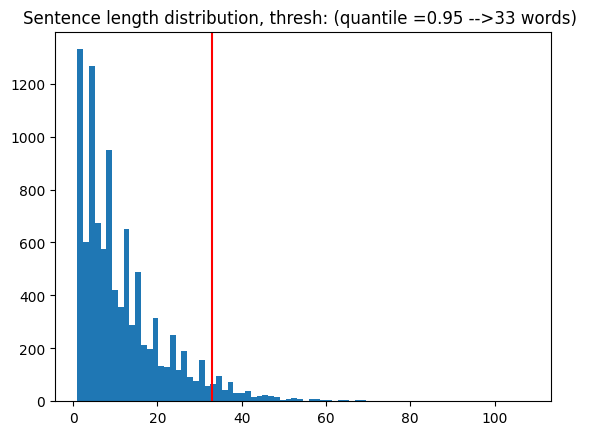

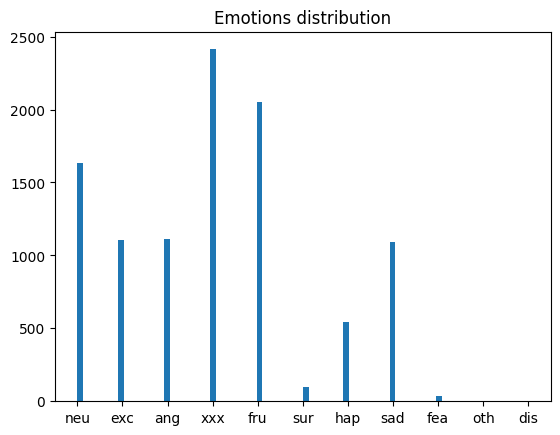

In [4]:
X = df["sentence"].copy()
y = df["emotion"].copy()


# drawing plot of the sentences length distribution

lengths = [len(t.split(' ')) for t in X]
quantile = 0.95
thresh = int(np.quantile(lengths, quantile))
plt.hist(lengths, bins = len(set(lengths)))
plt.title(f"Sentence length distribution, thresh: (quantile ={quantile} -->{thresh} words) ")
plt.axvline(x = thresh, color = 'r', label = 'axvline - full height')
plt.show()

# drawing plot of the emotions distribution
plt.hist(y, bins = len(set(lengths)))
plt.title("Emotions distribution")
plt.show()

### Dataset split

In [5]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed)# stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=random_seed)

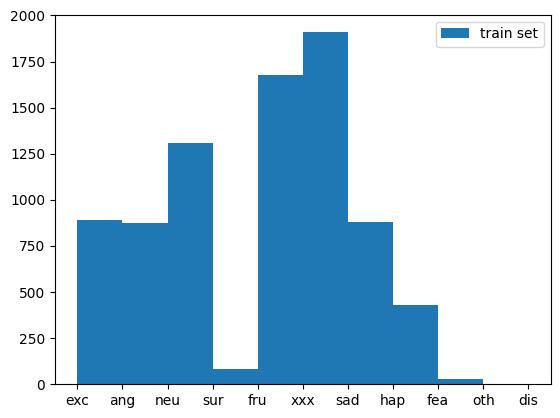

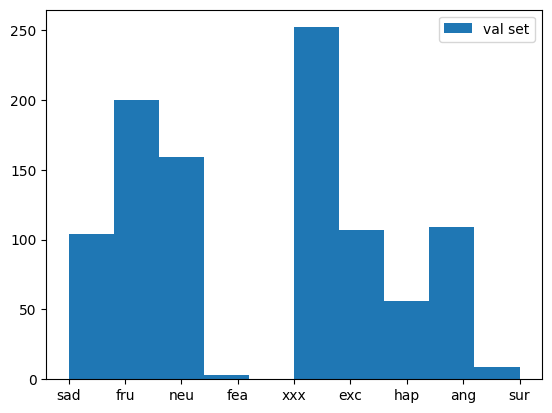

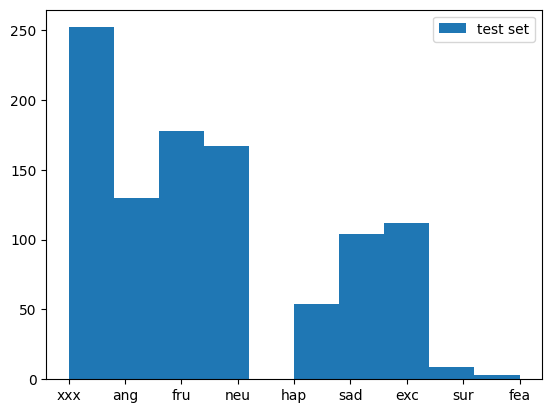

In [92]:
plt.hist(y_train, label="train set")
plt.legend()
plt.show()
plt.hist(y_val, label = "val set")
plt.legend()
plt.show()
plt.hist(y_test, label = "test set")
plt.legend()
plt.show()

### Tokenization of sentences

In [6]:
# setting length cut-limit for the sentences
maxlen = thresh

x_train_albert = tokenizer(
    text = X_train.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_val_albert = tokenizer(
    text = X_val.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_test_albert = tokenizer(
    text = X_test.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = "max_length",
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)
     

### One-hot encoding of labels

In [7]:
encoded_dict= {'ang':0, 'dis':1, 'exc':2, 'fea':3, 'fru':4, 'hap':5,'neu':6, 'oth':7, 'sad':8, 'sur':9, 'xxx':10}

y_train_albert = y_train.map(encoded_dict)

y_test_albert = y_test.map(encoded_dict)

y_val_albert = y_val.map(encoded_dict)

print("Before one-hot encoding: \n")
print(y_train)
print("Label count by class: \n")
print(np.unique(y_train,return_counts=True))

print("After one-hot encoding: \n")
print(y_train_albert) 
print("Label count by class: \n")
print(np.unique(y_train_albert,return_counts=True))


# testing if the label vector has still same dimension
assert len(y_train) == len(y_train_albert)
assert len(y_val) == len(y_val_albert)
assert len(y_test) == len(y_test_albert)

# checking if new vectors contain only integers
assert np.array_equal(y_train_albert, y_train_albert.astype(int))
assert np.array_equal(y_val_albert, y_val_albert.astype(int))
assert np.array_equal(y_test_albert, y_test_albert.astype(int))


Before one-hot encoding: 

3833    exc
8973    ang
994     neu
5324    ang
8403    ang
       ... 
9172    sad
8558    hap
7465    exc
9226    exc
7426    exc
Name: emotion, Length: 8079, dtype: object
Label count by class: 

(array(['ang', 'dis', 'exc', 'fea', 'fru', 'hap', 'neu', 'oth', 'sad',
       'sur', 'xxx'], dtype=object), array([ 872,    1,  889,   29, 1675,  431, 1308,    3,  881,   81, 1909]))
After one-hot encoding: 

3833    2
8973    0
994     6
5324    0
8403    0
       ..
9172    8
8558    5
7465    2
9226    2
7426    2
Name: emotion, Length: 8079, dtype: int64
Label count by class: 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 872,    1,  889,   29, 1675,  431, 1308,    3,  881,   81, 1909]))


## ALBERT

In [74]:
# input
input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
# pretrained 
embeddings = albert([input_ids, input_mask])[0] #(0 is the last hidden layer, 1 means pooler output)
# last layers and output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation = 'relu')(out)
y = Dense(11, activation = 'Softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs = y)
model.layers[2].trainable = True

In [65]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 33)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  11683584   ['input_ids[0][0]',              
 )                              thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 33,                                               
                                 768),                                                      

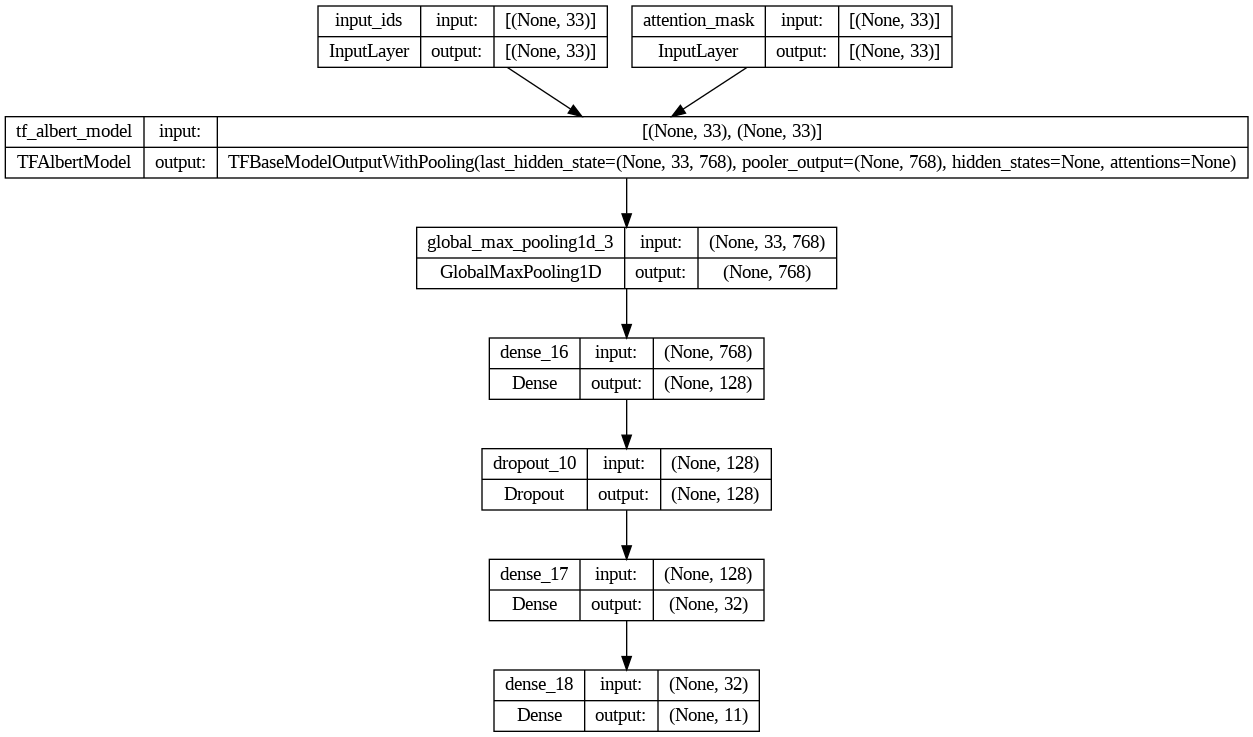

In [75]:
tf.keras.utils.plot_model(model,show_shapes=True)

### Model training

In [76]:
#function to plot train history
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(range(1, len(model_history.history[m])+1), model_history.history[m])
    plt.plot(range(1, len(model_history.history[val_m])+1),model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#### Training settings

In [83]:
optimizer=Adam(
    learning_rate = 1e-05, # this learning rate is for bert model, taken from hugging face site
)

# set loss and metrics 
loss = 'categorical_crossentropy'#CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy(name='balanced_accuracy',dtype='float32')
f1 = tfa.metrics.F1Score(num_classes=11,average='macro')

# compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric,f1]
)

#### Training

In [84]:
albert_history = model.fit(
    x = {'input_ids': x_train_albert['input_ids'],'attention_mask':x_train_albert['attention_mask']},
    y = to_categorical(y_train_albert),
    validation_data = ({'input_ids':x_val_albert['input_ids'],'attention_mask':x_val_albert['attention_mask']}, to_categorical(y_val_albert)),
    epochs=7, 
    batch_size=80,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=2, verbose=1, mode='max', restore_best_weights=True)]
)

Epoch 1/7


101/101 [==============================] - 79s 575ms/step - loss: 0.9344 - balanced_accuracy: 0.7143 - f1_score: 0.4602 - val_loss: 2.1543 - val_balanced_accuracy: 0.3794 - val_f1_score: 0.2313
Epoch 2/7
101/101 [==============================] - 54s 533ms/step - loss: 0.8304 - balanced_accuracy: 0.7515 - f1_score: 0.4930 - val_loss: 2.1809 - val_balanced_accuracy: 0.3824 - val_f1_score: 0.2309
Epoch 3/7
101/101 [==============================] - 54s 531ms/step - loss: 0.8060 - balanced_accuracy: 0.7542 - f1_score: 0.4883 - val_loss: 2.2391 - val_balanced_accuracy: 0.3864 - val_f1_score: 0.2337
Epoch 4/7
101/101 [==============================] - 54s 533ms/step - loss: 0.7358 - balanced_accuracy: 0.7797 - f1_score: 0.5292 - val_loss: 2.3289 - val_balanced_accuracy: 0.3714 - val_f1_score: 0.2451
Epoch 5/7
101/101 [==============================] - 54s 532ms/step - loss: 0.7225 - balanced_accuracy: 0.7788 - f1_score: 0.5243 - val_loss: 2.3714 - val_balanced_accuracy: 0.3554 - val_f1_scor

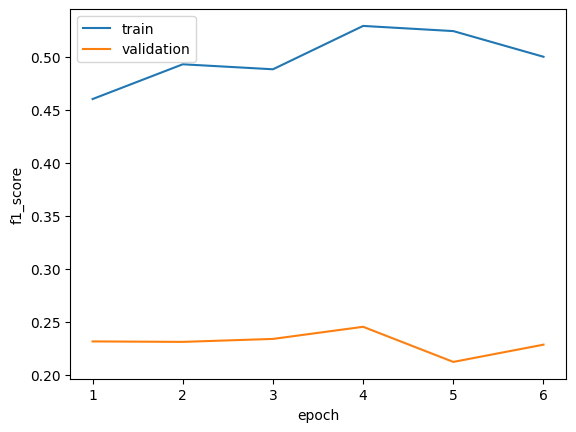

In [85]:
plot_history(albert_history,['f1_score','val_f1_score'])

### Testing

In [89]:
y_pred_albert = model.predict({'input_ids':x_test_albert['input_ids'],'attention_mask':x_test_albert['attention_mask']})
# convertion of the guessed label in integer labels
y_pred_albert = np.argmax(y_pred_albert, axis = 1)

f1_macro = f1_score(y_test_albert,y_pred_albert, average='macro')

print("The final F1-score macro avg obtained on the test set is F1 = {}".format(f1_macro))

32/32 [==============================] - 3s 82ms/step
The final F1-score macro avg obtained on the test set is F1 = 0.31787804142646564


In [90]:
print(classification_report(y_test_albert,y_pred_albert))

              precision    recall  f1-score   support

           0       0.49      0.39      0.44       130
           2       0.39      0.51      0.44       112
           3       0.00      0.00      0.00         3
           4       0.39      0.46      0.42       178
           5       0.30      0.20      0.24        54
           6       0.39      0.31      0.35       167
           8       0.44      0.49      0.47       104
           9       0.14      0.11      0.12         9
          10       0.38      0.39      0.38       252

    accuracy                           0.40      1009
   macro avg       0.33      0.32      0.32      1009
weighted avg       0.40      0.40      0.39      1009



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_albert,y_pred_albert)

0.398414271555996

## Bi-LSTM

### Tokenization

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
# creating tokenizer and fitting it on the training test
tokenizer = Tokenizer(num_words = 10000, oov_token='')
tokenizer.fit_on_texts(X)

# printing a tokenization example
print("## Before tokenization: ")
print(X[0])
print("## After tokenization: ")
X_train_list = X_train.to_list()
print(tokenizer.texts_to_sequences(X_train_list[0]))

## Before tokenization: 
As a matter of fact, the real cause of that row was Peter Burden.
## After tokenization: 
[[2], [], [678], [1058], [7], [1], [], [], [1476], [2133], [2], [1], [1], [], [7], [1567], [1475], [329], [1476], [], [1476], [2133], [2], [292], [], [], [2], [], [1], [1], [1475], [1], [], [1], [1475], [329], [1], [2047], [1058], [], [1], [1475], [1476], [], [2], [1], [1476], [1058], [2047], [1058], [292], [1476], [1058], [415], [], [1567], [329], [1476], [], [2521], [329], [292], [1476], [], [1476], [2133], [2], [1], [1], [], [7], [1567], [1475], [329], [1476], [], [1476], [2133], [2], [292], [], [1551], [1475], [2047], [], [7], [], [678], [2], [1], [329], [1476], [1058], []]


In [ ]:

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(4000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(7,activation='Softmax')
        
])

f1 = tfa.metrics.F1Score(num_classes=7,average='macro')
accuracy = 'accuracy'

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=10e-3),
    metrics = [accuracy,f1]
)

In [ ]:
model.summary()

In [ ]:
plot_model(model)

In [ ]:
bilstm_history = model.fit(
    padded_train_seq, to_categorical(y_train_litemodel),
    validation_data=(padded_val_seq, to_categorical(y_val_litemodel)),
    epochs =8,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=3, verbose=1, mode='max', restore_best_weights=True)],
    batch_size=70
)